In [2]:
import sbibm
import numpy as np
import torch
import pickle
import pyro
from tqdm import tqdm
from joblib import Parallel, delayed
from pyro.distributions.empirical import Empirical
from functools import reduce
from scipy.optimize import linear_sum_assignment
import timeit

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils
from sbi import analysis

# distances
from scipy.spatial.distance import directed_hausdorff
from torch.nn.functional import normalize

sbibm.get_available_tasks()

['gaussian_mixture',
 'two_moons',
 'slcp',
 'gaussian_linear_uniform',
 'sir',
 'bernoulli_glm',
 'lotka_volterra',
 'gaussian_linear',
 'slcp_distractors',
 'bernoulli_glm_raw']

In [3]:
def euclidean(x,y):
    return torch.linalg.norm(x-y,axis=1)

def euclidean2(x,y):
    return torch.cdist(x, y, p=2)

def euclidean_sq(x,y):
    return euclidean(x,y)**2

In [4]:
def thetas_from_prior(prior, num_samples = 64):
    return prior.sample((num_samples,))

def make_theta_grid(prior_min, prior_max, num_points):
    
    assert len(prior_min) == len(prior_max), "prior_min and prior_max must be equal in length"
    assert len(prior_max) == len(num_points), "num_points must be equal in length to prior_min and prior_max"

    coords = []
    for i in range(len(prior_min)):
        coords.append(torch.linspace(prior_min[i], prior_max[i], num_points[i]+2)[1:-1])

    return torch.cartesian_prod(*coords)

def make_theta_covering_grid(thetas, num_points, quantile = 0.98):
    """Produces a grid to cover a set of thetas. Covers each dimension
    by taking central quantile of that dimension according to 'quantile'
    parameter. So, e.g. quantile = 1. gives full cover.

    Args:
        thetas: thetas, such as drawn from prior of a simulator.
        num_points: The number of thetas along each axis of the new 
        quantile: Central quantile. Equivalent for each dimension.

    Returns:
        tensor: thetas representing the grid, each row being one set of parameters.
    """

    assert quantile > 0.5, "please choose quantile > 0.5"

    quant_min = float((1-quantile)/2)
    quant_max = float(quantile + quant_min)

    quantiles = torch.quantile(thetas,torch.tensor([quant_min,quant_max]),axis=0)
    
    prior_max = quantiles[1]
    prior_min = quantiles[0]

    return make_theta_grid(prior_min,prior_max, num_points)
    
def make_theta_covering_grid(thetas, num_points, quantile = 0.98):
    """Produces a grid to cover a set of thetas. Covers each dimension
    by taking central quantile of that dimension according to 'quantile'
    parameter. So, e.g. quantile = 1. gives full cover.

    Args:
        thetas: thetas, such as drawn from prior of a simulator.
        num_points: The number of thetas along each axis of the new 
        quantile: Central quantile. Equivalent for each dimension.

    Returns:
        tensor: thetas representing the grid, each row being one set of parameters.
    """

    assert quantile > 0.5, "please choose quantile > 0.5"

    quant_min = float((1-quantile)/2)
    quant_max = float(quantile + quant_min)

    quantiles = torch.quantile(thetas,torch.tensor([quant_min,quant_max]),axis=0)
    
    prior_max = quantiles[1]
    prior_min = quantiles[0]

    return make_theta_grid(prior_min,prior_max, num_points)

## Point manipulations

Other idea: sample from prior and place in ball around true point.

In [5]:
def rand_ball_around_point(x, scale, num_points):
    points_to_add = []
    for _ in range(num_points):
        points_to_add.append(torch.rand(x.shape)*scale)

    points = [x + point for point in points_to_add]

    return torch.stack(points)

In [6]:
def minimum_matching(x_old, x_new, epsilon):
    if x_old is None:
        return x_new
    weights = torch.cdist(x_old, x_new)
    row_ind, col_ind = linear_sum_assignment(weights)
    return (1-epsilon)*x_old + epsilon*x_new[col_ind]

## Simulator

In [7]:
slcp2 = sbibm.get_task("slcp")  # See sbibm.get_available_tasks() for all tasks
slcp_simulator2 = slcp2.get_simulator()
slcp_observation2 = slcp2.get_observation(num_observation=1)  # 10 per task
prior_min = [-3]*5
prior_max = [3]*5
slcp_prior_2 = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

In [52]:
def get_slcp_simulator(points, seed = None):

    def simulator(theta, input = None, seed = seed):
        if seed is not None:
            torch.manual_seed(seed)
            # np.random.seed(seed)
            # pyro.set_rng_seed(seed)
        if input is None:
            full_data = slcp_simulator2(theta)
        else:
            full_data = input
        return euclidean_sq(points, full_data)
    
    return simulator

### Get Simulator

In [68]:
def rand_ball_around_point(x, scale, num_points):
    points_to_add = torch.rand((num_points, x.shape[1]))*scale

    points = x + points_to_add

    return points

In [73]:
points = rand_ball_around_point(slcp_observation2, 0.5, 30)
rand_simulator = get_slcp_simulator(points)
ref_point = rand_simulator(None, slcp_observation2)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 269 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

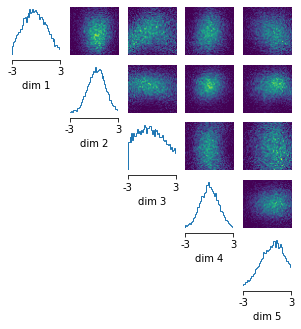

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 92 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

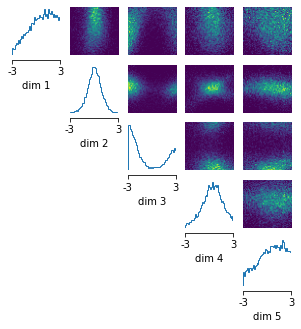

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 119 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

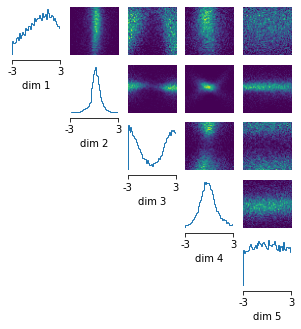

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

Using SNPE-C with atomic loss
 Neural network successfully converged after 138 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

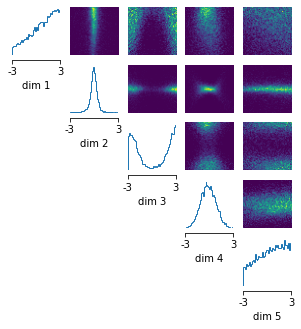

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

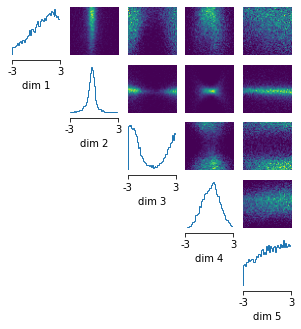

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

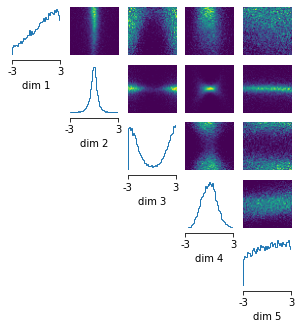

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 66 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

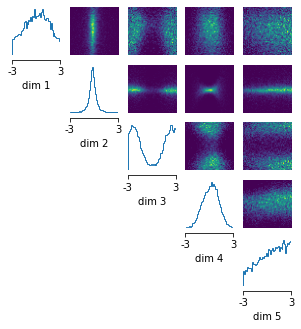

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

KeyboardInterrupt: 

In [76]:
num_rounds = 10
posteriors_rand= []
simulator, prior = prepare_for_sbi(rand_simulator, slcp_prior_2)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors_rand.append(posterior)
    proposal = posterior.set_default_x(ref_point)
    samples = posterior.sample((10000,))
    analysis.pairplot(samples,
                        limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                        ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                        figsize=(5,5),
                        points_offdiag={'markersize': 6},
                        points_colors='r'); 
    plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9980 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


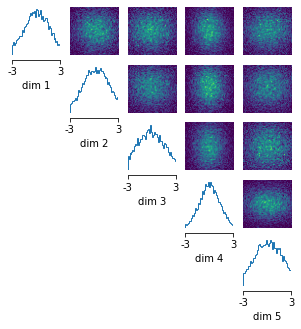

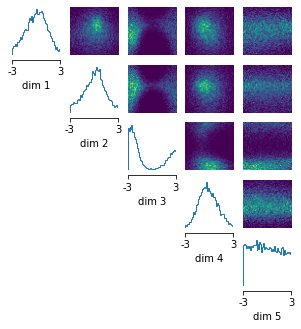

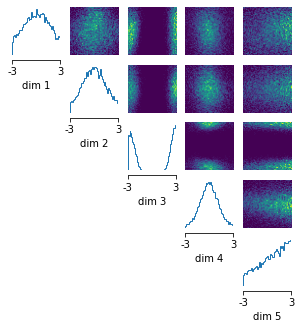

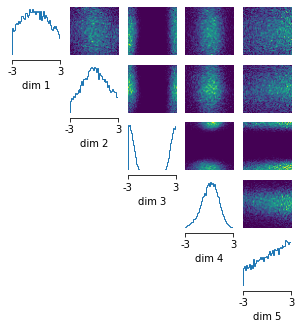

In [72]:
samples = posteriors_rand[0].sample((10000,))
analysis.pairplot(samples,
                        limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                        ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                        figsize=(5,5),
                        points_offdiag={'markersize': 6},
                        points_colors='r'); 

samples = posteriors_rand[1].sample((10000,))
analysis.pairplot(samples,
                        limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                        ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                        figsize=(5,5),
                        points_offdiag={'markersize': 6},
                        points_colors='r'); 

samples = posteriors_rand[4].sample((10000,))
analysis.pairplot(samples,
                        limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                        ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                        figsize=(5,5),
                        points_offdiag={'markersize': 6},
                        points_colors='r'); 

samples = posteriors_rand[-1].sample((10000,))
analysis.pairplot(samples,
                        limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                        ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                        figsize=(5,5),
                        points_offdiag={'markersize': 6},
                        points_colors='r'); 

## Kernel and summary functions

In [12]:
def get_summary_fun(ref_data):

    def summary_fun_broadcast(xs):
        if xs.dim() == 1:
            return euclidean(xs,ref_data)
        elif xs.dim() == 2:
            scores=[euclidean(x,ref_data) for x in xs]
            return torch.stack(scores)

    return summary_fun_broadcast

In [13]:
def kernel(xs):
    
    distances = xs[:,0]
    var = torch.var(distances)

    def wrapped(x):
        return torch.exp(-0.5*x[:,0]**2/(var))
    
    return wrapped

## Updatable Summaries

In [15]:
thetas_rand = slcp_prior_2.sample((32,))
points_rand = slcp_simulator2(thetas_rand)
old_points = points_rand

In [ ]:
num_rounds = 10
# posteriors_adapt = []
# simulator, prior = prepare_for_sbi(slcp_simulator2, slcp_prior_2)
# summary_fun = get_summary_fun(points_rand)
# rand_obs = summary_fun(slcp_observation2)
# proposal = prior
# inference = SNPE(prior=prior)
# for i in range(num_rounds):
#     theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000, num_workers=7)
#     density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(summary_fun=summary_fun)
#     posterior = inference.build_posterior(density_estimator)
#     posteriors_adapt.append(posterior)
#     proposal = posterior.set_default_x(rand_obs)
#     # set for if > 0? First round we're still using x which has been sampled from the prior.
#     # Or move below first line.
#     new_points = x[:32]
#     ref_points = minimum_matching(old_points, new_points, 0.1)
#     old_points = new_points
#     new_points = ref_points
#     summary_fun = get_summary_fun(ref_points)
#     rand_obs = summary_fun(slcp_observation2)
#     samples = posterior.sample((10000,))
#     analysis.pairplot(samples,
#                         limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
#                         ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
#                         figsize=(5,5),
#                         points_offdiag={'markersize': 6},
#                         points_colors='r'); 
#     plt.show()

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

 Neural network successfully converged after 79 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

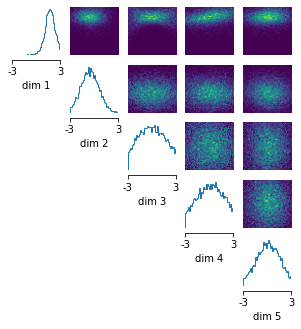

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 100 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

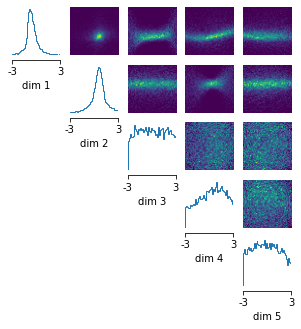

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

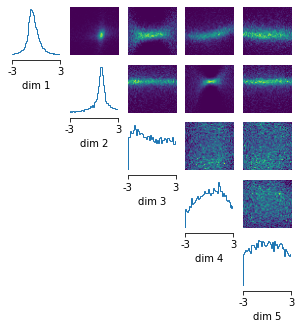

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

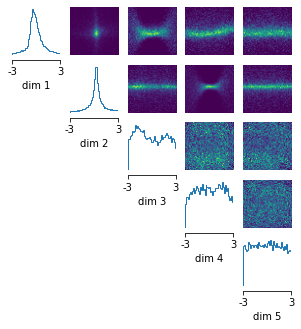

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 84 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9903 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


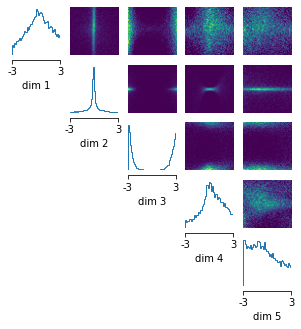

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 912 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9902 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


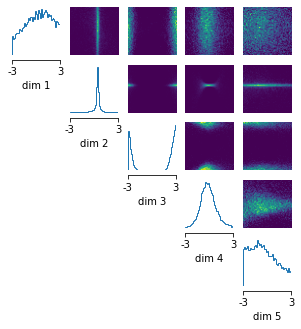

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 87 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

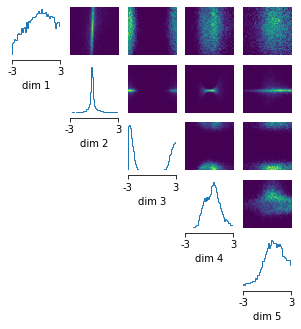

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

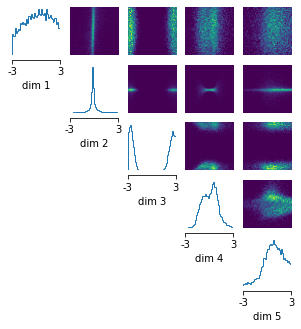

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

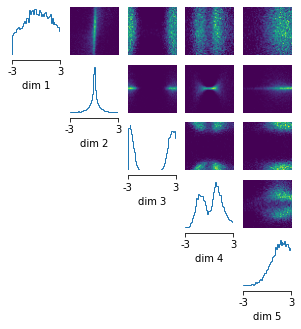

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

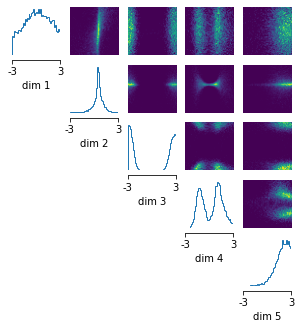

In [18]:
num_rounds = 10
posteriors_adapt = []
simulator, prior = prepare_for_sbi(slcp_simulator2, slcp_prior_2)
summary_fun = get_summary_fun(points_rand)
rand_obs = summary_fun(slcp_observation2)
proposal = prior
inference = SNPE(prior=prior)
points = None
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000, num_workers=7)
    post_sample = x[:32]
    points = minimum_matching(points, post_sample, 0.1)
    summary_fun = get_summary_fun(points)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(summary_fun=summary_fun)
    posterior = inference.build_posterior(density_estimator)
    posteriors_adapt.append(posterior)
    proposal = posterior.set_default_x(rand_obs)
    rand_obs = summary_fun(slcp_observation2)
    samples = posterior.sample((10000,))
    analysis.pairplot(samples,
                        limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                        ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                        figsize=(5,5),
                        points_offdiag={'markersize': 6},
                        points_colors='r'); 
    plt.show()

## Learnable summaries

There are a couple of ways of learning distance-based summaries.

1. We use a strategy as above, with the matching distances, but with learnable epsilon. Can also learn the epsilon independently for each matching (i.e. point-to-point).

2. We fix a set of points and learn a linear mapping of these points, after which we calculate the distances.

In the latter case, if we set the initial points as a basis for the space, then any set of output points should be possible. Begin with strategy 1.

In [51]:
class BestMatching(torch.nn.Module):
    def __init__(self, old_points, new_points):
        """
        Instantiate parameter to be used as weighting.
        """
        super().__init__()
        self.theta = torch.nn.Parameter(torch.tensor(torch.pi/2))
        self.old_points = old_points
        self.new_points = new_points
        
    def forward(self, x):
        # (1-eps) * old_points + eps * new_points
        # point_update = old_points + (torch.cos(self.theta)**2)*(self.new_points - self.old_points)
        point_update = minimum_matching(self.old_points, self.new_points, torch.cos(self.theta)**2) #move to init then reinitialise?
        distances = torch.cdist(x, point_update)

        return distances

In [74]:
class BestMatching2(torch.nn.Module):
    def __init__(self, old_points, new_points):
        """
        Instantiate parameter to be used as weighting.
        """
        super().__init__()
        num_params = len(new_points)
        
        self.thetas = torch.nn.Parameter(torch.full((num_params,1),torch.pi/2))
        self.old_points = old_points
        self.new_points = new_points
        
    def forward(self, x):
        # (1-eps) * old_points + eps * new_points
        # point_update = old_points + (torch.cos(self.theta)**2)*(self.new_points - self.old_points)
        point_update = minimum_matching(self.old_points, self.new_points, torch.cos(self.thetas)**2) #move to init then reinitialise?
        distances = torch.cdist(x, point_update)

        return distances

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 170 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

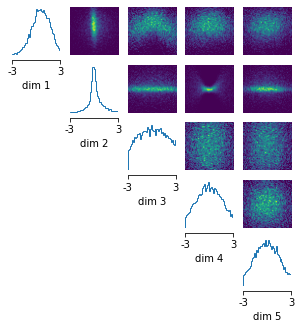

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

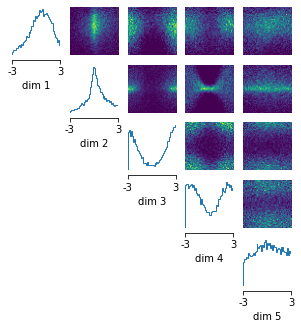

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 108 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

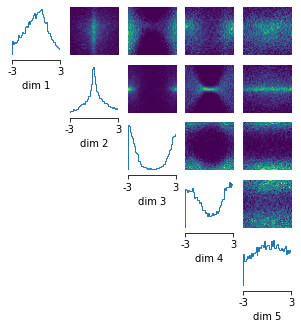

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

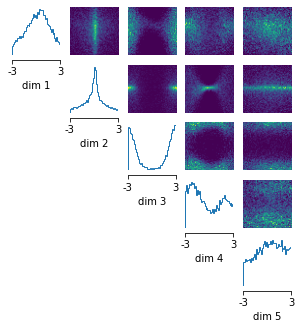

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

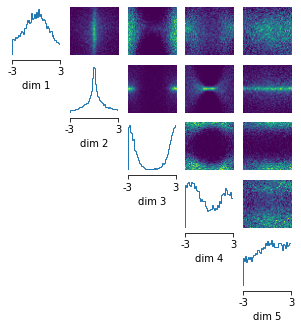

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 70 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

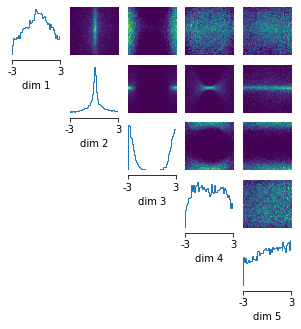

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 46 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

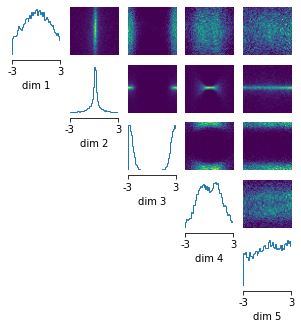

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 87 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9932 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


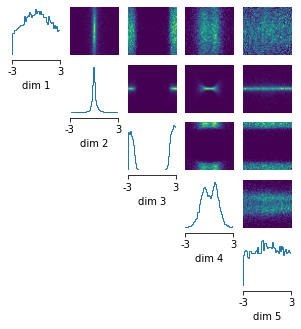

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 916 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9926 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


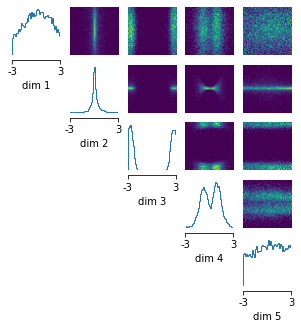

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 917 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9929 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


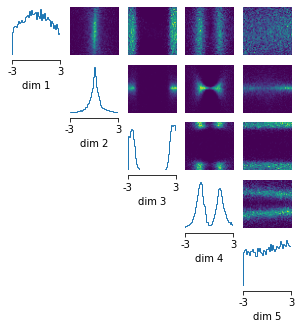

In [101]:
num_rounds = 10
posteriors_embed = []
simulator, prior = prepare_for_sbi(slcp_simulator2, slcp_prior_2)
proposal = prior
old_points = None
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000, num_workers=7)
    if i==0: # Doing nothing?
        embedding_net = BestMatching(old_points, x[:32])
        neural_posterior = utils.posterior_nn(model="maf", embedding_net=embedding_net)
        inference = SNPE(prior=prior, density_estimator=neural_posterior)
    else:
        density_estimator._embedding_net = BestMatching(old_points, x[:32])
        old_points = x[:32]
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors_embed.append(posterior)
    proposal = posterior.set_default_x(slcp_observation2)
    samples = posterior.sample((10000,))
    analysis.pairplot(samples,
                        limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                        ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                        figsize=(5,5),
                        points_offdiag={'markersize': 6},
                        points_colors='r'); 
    plt.show()

In [76]:
num_rounds = 10
posteriors_embed2 = []
simulator, prior = prepare_for_sbi(slcp_simulator2, slcp_prior_2)
proposal = prior
old_points = None
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000, num_workers=7)
    if i==0: # Doing nothing?
        embedding_net = BestMatching2(old_points, x[:32])
        neural_posterior = utils.posterior_nn(model="maf", embedding_net=embedding_net)
        inference = SNPE(prior=prior, density_estimator=neural_posterior)
    else:
        density_estimator._embedding_net = BestMatching2(old_points, x[:32])
        old_points = x[:32]
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors_embed2.append(posterior)
    proposal = posterior.set_default_x(slcp_observation2)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 169 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 71 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 183 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 934 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

Using SNPE-C with atomic loss
 Neural network successfully converged after 63 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 919 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 932 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 942 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 924 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 67 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 954 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 68 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

Using SNPE-C with atomic loss
 Neural network successfully converged after 99 epochs.

In [99]:
class AllPoints(torch.nn.Module):
    def __init__(self, init_points):
        """
        Instantiate parameter to be used as weighting.
        """
        super().__init__()
        # self.linear_layer = torch.nn.Linear(8, num_points)
        # self._matrix = torch.nn.Parameter(torch.randn((8,num_points)))
        self._matrix = torch.nn.Parameter(init_points)
        self._initial_basis = torch.eye(8)
        
    def forward(self, x):
        # (1-eps) * old_points + eps * new_points
        # point_update = old_points + (torch.cos(self.theta)**2)*(self.new_points - self.old_points)
        # points_to_compare = self.linear_layer(self._initial_basis).T
        points_to_compare = self._matrix @ self._initial_basis

        #essentially we're actually just interested in weight matrix
        distances = torch.cdist(x, points_to_compare)
        

        return distances

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

 Neural network successfully converged after 211 epochs.

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

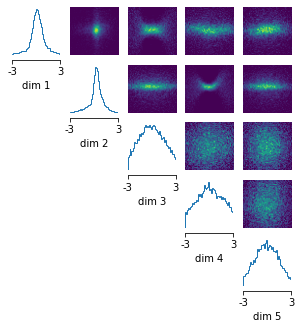

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

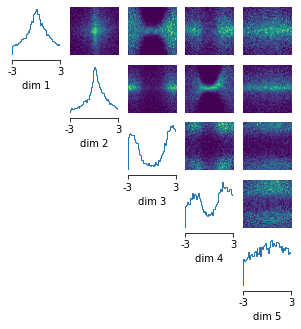

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 79 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

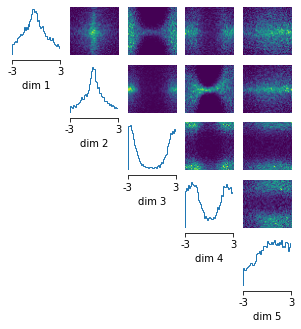

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 84 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

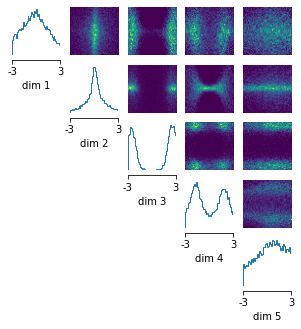

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

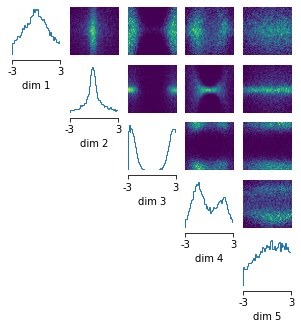

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

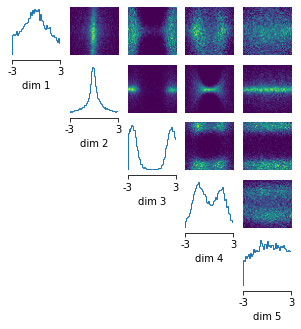

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 105 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

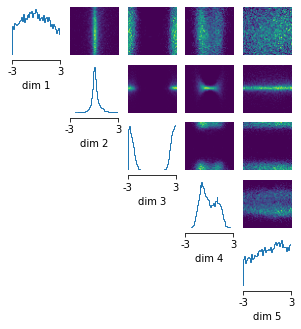

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

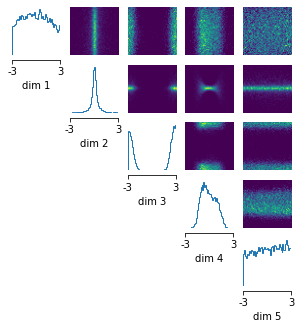

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

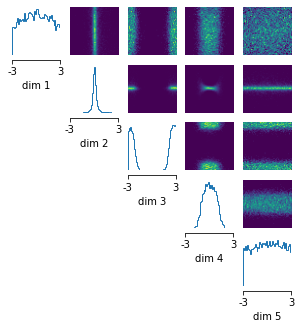

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

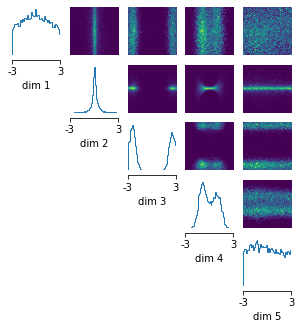

In [100]:
num_rounds = 10
posteriors_embed3 = []
simulator, prior = prepare_for_sbi(slcp_simulator2, slcp_prior_2)
proposal = prior
# embedding_net = AllPoints(32)
# neural_posterior = utils.posterior_nn(model="maf", embedding_net=embedding_net)
# inference = SNPE(prior=prior, density_estimator=neural_posterior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000, num_workers=7)
    if i == 0:
        embedding_net = AllPoints(x[:32])
        neural_posterior = utils.posterior_nn(model="maf", embedding_net=embedding_net)
        inference = SNPE(prior=prior, density_estimator=neural_posterior)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors_embed3.append(posterior)
    proposal = posterior.set_default_x(slcp_observation2)
    samples = posterior.sample((10000,))
    analysis.pairplot(samples,
                        limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                        ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                        figsize=(5,5),
                        points_offdiag={'markersize': 6},
                        points_colors='r'); 
    plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

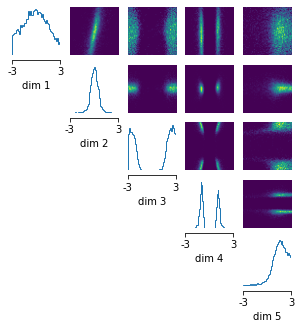

In [61]:
samples = posteriors_embed[-1].sample((10000,))
analysis.pairplot(samples,
                    limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                    ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                    figsize=(5,5),
                    points_offdiag={'markersize': 6},
                    points_colors='r'); 
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9915 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


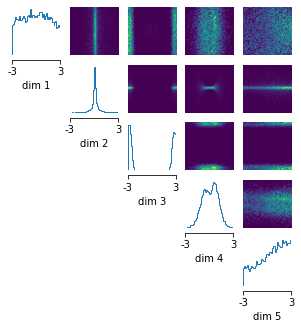

In [78]:
samples = posteriors_embed2[-1].sample((10000,))
analysis.pairplot(samples,
                    limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                    ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                    figsize=(5,5),
                    points_offdiag={'markersize': 6},
                    points_colors='r'); 
plt.show()

## Plots

In [102]:
# Try the full simulator sans grid.

num_rounds = 10
posteriors_full = []
simulator, prior = prepare_for_sbi(slcp_simulator2, slcp_prior_2)
proposal = prior
neural_posterior = utils.posterior_nn(model="maf", embedding_net=torch.nn.Identity())
inference = SNPE(prior=prior, density_estimator=neural_posterior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors_full.append(posterior)
    proposal = posterior.set_default_x(slcp_observation2)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbi

 Neural network successfully converged after 110 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 62 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 73 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batche

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

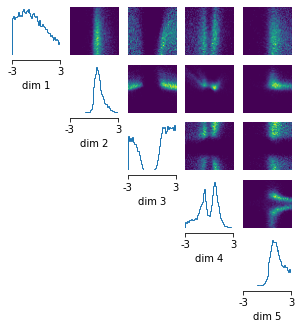

In [103]:
samples = posterior.sample((10000,))
analysis.pairplot(samples,
                    limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                    ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                    figsize=(5,5),
                    points_offdiag={'markersize': 6},
                    points_colors='r'); 
plt.show()

In [62]:
def compare_plots(posterior_1, posterior_2, reference_samples):
    fig, axes = plt.subplots(5,15,figsize=(15, 5))

    samples = posterior_1.sample((10000,))
    analysis.pairplot(samples,
                            limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                            ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                            figsize=(5,5),
                            points_offdiag={'markersize': 6},
                            points_colors='r',
                            fig = fig,
                            axes=axes[:,:5]); 

    samples = posterior_2.sample((10000,))
    analysis.pairplot(samples,
                            limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                            ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                            figsize=(5,5),
                            points_offdiag={'markersize': 6},
                            points_colors='r',
                            fig = fig,
                            axes = axes[:,5:]);

    analysis.pairplot(reference_samples,
                        limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                        ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                        figsize=(5,5),
                        points_offdiag={'markersize': 6},
                        points_colors='r',
                        fig = fig,
                        axes = axes[:,10:]);
    
    plt.show()

## Reference

In [8]:
ref_samples = points = slcp2._sample_reference_posterior(100000, observation = slcp_observation2)

Sequential Importance Resampling (SIR)
/home/sragy/sb_inference/sbibm/sbibm/tasks/slcp/task.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  m = torch.stack(


  0%|          | 0/1000 [00:00<?, ?it/s]

Finished sampling
/home/sragy/sb_inference/sbibm/sbibm/utils/torch.py:53: UserWarning: Using numpy.random.choice.
  warnings.warn("Using numpy.random.choice.")
Finished resampling
Unique particles: 36645 out of 100000
Finished after 180.118 seconds
Get proposal distribution called


Epoch: 1  --  validation loss 7.056605670166015
Epoch: 2  --  validation loss 6.868180224609375
Epoch: 3  --  validation loss 6.798548718261719
Epoch: 4  --  validation loss 6.743079217529297
Epoch: 5  --  validation loss 6.737862878417968
Epoch: 6  --  validation loss 6.706847668457031
Epoch: 7  --  validation loss 6.724873767089844
Epoch: 8  --  validation loss 6.683561865234375
Epoch: 9  --  validation loss 6.681870953369141
Epoch: 10  --  validation loss 6.683703002929687
Epoch: 11  --  validation loss 6.671951440429687
Epoch: 12  --  validation loss 6.675587573242187
Epoch: 13  --  validation loss 6.628076971435547
Epoch: 14  --  validation loss 6.618745812988282
Epoch: 15  --  validation loss 6.611464642333984
Epoch: 16  --  validation loss 6.611553454589844
Epoch: 17  --  validation loss 6.584865881347656
Epoch: 18  --  validation loss 6.583066729736328
Epoch: 19  --  validation loss 6.572487615966797
Epoch: 20  --  validation loss 6.5784169250488285
Epoch: 21  --  validation lo

Proposal distribution is set up, took 7488.509sec
Rejection sampling
Finding M


Epoch: 180  --  validation loss 5.498898004150391


  0%|          | 0/1000 [00:00<?, ?it/s]

log(M): -11.865558624267578
Rejection sampling


  0%|          | 0/100000 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbibm/sbibm/utils/torch.py:53: UserWarning: Using numpy.random.choice.
  warnings.warn("Using numpy.random.choice.")
/home/sragy/DISPyprob/nflows/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853042/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  outputs, _ = torch.triangular_solve(
Acceptance rate: 0.000128114
Finished after 59015.557 seconds


In [9]:
with open('slcp_obs1_posterior.pkl', 'wb') as f:
    pickle.dump(ref_samples,f)

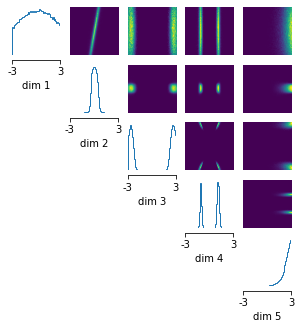

In [10]:
analysis.pairplot(ref_samples,
                    limits=[[-3,3], [-3,3],[-3,3],[-3,3],[-3,3]],
                    ticks=[[-3,3],[-3,3],[-3,3],[-3,3],[-3,3]],
                    figsize=(5,5),
                    points_offdiag={'markersize': 6},
                    points_colors='r'); 
plt.show()

## Roughs

In [7]:
slcp2 = sbibm.get_task("slcp")  # See sbibm.get_available_tasks() for all tasks
slcp_simulator2 = slcp2.get_simulator()
slcp_observation2 = slcp2.get_observation(num_observation=1)  # 10 per task
prior_min = [-3]*5
prior_max = [3]*5
slcp_prior_2 = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))



In [8]:
pdist = torch.nn.PairwiseDistance()

In [38]:
thetas = thetas_from_prior(slcp_prior_2, num_samples=3)
thetas2 = thetas_from_prior(slcp_prior_2, num_samples=3)
points = slcp_simulator2(thetas)
points2 = slcp_simulator2(thetas2)


In [28]:
%timeit euclidean(point, points)

46.9 µs ± 6.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [29]:
%timeit torch.cdist(point, points)[0]

107 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [41]:
r_ind, c_ind = minimum_matching(points, points2, None)

In [46]:
points[r_ind]

tensor([[ -2.1801,  -3.9963,  -5.0748, -12.5433,   4.2895,   9.4949,  -8.9771,
         -23.1863],
        [  0.4988,   0.5665,   0.3156,   0.4967,   0.2686,   3.1949,   1.1192,
           5.1624],
        [ -2.6468,   0.8646,  -2.4887,   0.8669,  -0.0702,   0.8518,  -2.5502,
           0.8637]])

In [51]:
minimum_matching(points, points2, 0)

tensor([[ -2.1801,  -3.9963,  -5.0748, -12.5433,   4.2895,   9.4949,  -8.9771,
         -23.1863],
        [  0.4988,   0.5665,   0.3156,   0.4967,   0.2686,   3.1949,   1.1192,
           5.1624],
        [ -2.6468,   0.8646,  -2.4887,   0.8669,  -0.0702,   0.8518,  -2.5502,
           0.8637]])

In [50]:
points

tensor([[ -2.1801,  -3.9963,  -5.0748, -12.5433,   4.2895,   9.4949,  -8.9771,
         -23.1863],
        [  0.4988,   0.5665,   0.3156,   0.4967,   0.2686,   3.1949,   1.1192,
           5.1624],
        [ -2.6468,   0.8646,  -2.4887,   0.8669,  -0.0702,   0.8518,  -2.5502,
           0.8637]])